# Flagship Cluster Catalogue Analysis

This notebook compares Euclid Flagship simulation cluster catalogue summary statistics with capish predictions.

In [1]:
import pyccl, sys
print("pyccl version:", pyccl.__version__)
print("pyccl path   :", pyccl.__file__)
print("python exe   :", sys.executable)

pyccl version: 3.2.1
pyccl path   : /sps/euclid/Users/cmurray/miniconda3/envs/cucount/lib/python3.11/site-packages/pyccl/__init__.py
python exe   : /sps/euclid/Users/cmurray/miniconda3/envs/cucount/bin/python


In [2]:
import torch

ModuleNotFoundError: No module named 'torch'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent.parent
sys.path.insert(0, str(project_root))

from modules.simulation import UniverseSimulator
import configparser

## 1. Load Flagship Summary Statistics

In [ ]:
# Load Flagship data
flagship_path = project_root / 'euclid_flagship_simulations' / 'flagship_cluster_catalogue_summary_statstics_DES_MoR_Mwl_scatter_Gamma0.7.npy'
flagship_data = np.load(flagship_path, allow_pickle=True).item()

print("Flagship data keys:", flagship_data.keys())
print("\nData shapes:")
for key, value in flagship_data.items():
    print(f"  {key}: {value.shape}")

Flagship data keys: dict_keys(['count_with_m200b_def', 'mean_log10m200b', 'count_with_m200c_def', 'mean_log10m200c'])

Data shapes:
  count_with_m200b_def: (5, 4)
  mean_log10m200b: (5, 4)
  count_with_m200c_def: (5, 4)
  mean_log10m200c: (5, 4)


In [ ]:
# Extract data for easier access
flagship_counts_m200b = flagship_data['count_with_m200b_def']
flagship_mean_log10m200b = flagship_data['mean_log10m200b']
flagship_counts_m200c = flagship_data['count_with_m200c_def']
flagship_mean_log10m200c = flagship_data['mean_log10m200c']

# Define binning from config
richness_edges = np.array([20, 30, 50, 80, 130, 200])
redshift_edges = np.array([0.2, 0.3, 0.4, 0.8, 1.0])

n_richness_bins = len(richness_edges) - 1
n_redshift_bins = len(redshift_edges) - 1

print(f"Number of richness bins: {n_richness_bins}")
print(f"Number of redshift bins: {n_redshift_bins}")
print(f"Total bins: {n_richness_bins * n_redshift_bins}")

Number of richness bins: 5
Number of redshift bins: 4
Total bins: 20


## 3. Generate Capish Predictions

In [ ]:
def create_capish_config(mr_params, cosmo_params, area_sr, richness_bins=None, redshift_bins=None):
    """Create Capish configuration matching the default capish.ini structure."""
    config = configparser.ConfigParser()

    # Unified parameters section
    config['parameters'] = {**cosmo_params, **mr_params}

    # Halo catalogue settings
    config['halo_catalogue'] = {
        'hmf_name': 'Tinker10',
        'bias_model': 'Tinker10',
        'recompute_SSC_fiducial': 'False',
        'name_sigma2ij_fullsky_file': 'sigma2ij_fullsky_fiducial_zmin={}_zmax={}_nzbins={}.pkl',
        'save_new_SSC_fiducial': 'False',
        'mass_def_overdensity_type': 'matter',
        'mass_def_overdensity_delta': '200',
        'Mstar': '10',
        's': '0.0',
        'q': '1.0',
        'sky_area': str(area_sr),
        'log10m_min': '13.3',
        'log10m_max': '16.0',
        'n_mass_bins': '500',
        'z_min': str(redshift_bins[0]) if redshift_bins is not None else '0.2',
        'z_max': str(redshift_bins[-1]) if redshift_bins is not None else '1.2',
        'n_redshift_bins': '500',
        'SSC': 'False',  # Can be overridden
        'Omega_c_fiducial': '0.25',
        'Omega_b_fiducial': '0.048254',
        'h_fiducial': '0.7',
        'sigma_8_fiducial': '0.8',
        'n_s_fiducial': '0.96'
    }

    # Cluster catalogue settings
    config['cluster_catalogue'] = {
        'gaussian_lensing_variable': 'Mwl',
        'theory_sigma_Mwl_gal': 'True',
        'DeltaSigma_Rmin': '1',
        'DeltaSigma_Rmax': '5',
        'ngal_arcmin2': '25',
        'shape_noise': '0.3',
        'concentration_mass_relation': 'Duffy08',
        'add_completeness': 'False',
        'params_completeness': '2.5, 0, 14., 0',
        'add_photometric_redshift': 'False',
        'add_purity': 'False',
        'params_purity': '2.5, 0, 1.5, 0',
        'add_selection': 'False'
    }

    config['cluster_catalogue.mass_observable_relation'] = {
        'which_relation': 'Gauss'
    }

    config['cluster_catalogue.photometric_redshift'] = {
        'sigma_z0': '0.02'
    }

    # Summary statistics
    if richness_bins is not None and redshift_bins is not None:
        config['summary_statistics'] = {
            'summary_statistic': 'binned_count_mean_mass',
            'Gamma': '0.7',
            'richness_edges': ','.join(map(str, richness_bins)),
            'redshift_edges': ','.join(map(str, redshift_bins))
        }
    else:
        config['summary_statistics'] = {
            'summary_statistic': 'binned_count_mean_mass',
            'Gamma': '0.7',
            'richness_edges': '20, 30, 50, 80, 130, 200',
            'redshift_edges': '0.2, 0.3, 0.4, 0.8, 1'
        }

    return config
# Mass-richness relation parameters
MASS_RICHNESS_PARAMS = {
    'M_min': 134896288259.1656,
    'alpha_lambda': -9.348,
    'beta_lambda': 0.75,
    'gamma_lambda': 0.0,
    'sigma_lambda': 0.3,
    'alpha_mwl': 0.0,
    'beta_mwl': 1.0,
    'gamma_mwl': 0.0,
    'sigma_Mwl_gal': 0.3,
    'sigma_Mwl_int': 0.0,
    'rho_0': 0.0,
    'rho_A': 0.0,
    'rho_alpha': 1.0,
    'rho_log10m0': 13
}

# Cosmological parameters
COSMO_PARAMS = {
    'Omega_m': '0.319',
    'sigma8': '0.813',
    'Omega_b': '0.048254',
    'h': '0.67',
    'ns': '0.96',
    'w0': '-1',
    'wa': '0'
}

# Flagship survey area 
FLAGSHIP_AREA_SR = 4*np.pi / 8 # 1 octant of the sky

print(f"Flagship survey area: {FLAGSHIP_AREA_SR} sr ({FLAGSHIP_AREA_SR * (180/np.pi)**2:.1f} deg²)")
print(f"Richness bins: {richness_edges}")
print(f"Redshift bins: {redshift_edges}")

Flagship survey area: 1.5707963267948966 sr (5156.6 deg²)
Richness bins: [ 20  30  50  80 130 200]
Redshift bins: [0.2 0.3 0.4 0.8 1. ]


In [ ]:
# Create config and initialize simulator
config = create_capish_config(MASS_RICHNESS_PARAMS, COSMO_PARAMS, FLAGSHIP_AREA_SR, richness_edges, redshift_edges)

# Initialize simulator with variable parameters
simulator = UniverseSimulator(
    default_config=config,
    variable_params_names=['Omega_m', 'sigma8', 'alpha_lambda', 'beta_lambda', 'gamma_lambda', 'M_min']
)

print("Simulator initialized successfully")
print(f"Mass function: {simulator.halo_catalogue_class.hmf}")
print(f"Mass definition: {simulator.halo_catalogue_class.mass_definition}")

/pbs/home/c/cmurray/cluster_likelihood/modules/cluster/model_log10mWL_Rmin{}_Rmax{}_ngal{}_ShapeNoise{}_M{}{}_cM{}.pkl
clmm not found - loading from /pbs/home/c/cmurray/cluster_likelihood/modules/cluster/model_log10mWL_Rmin1.0_Rmax5.0_ngal25.0_ShapeNoise0.3_M200matter_cMDuffy08.pkl


RuntimeError: Old pickle format detected. Please install clmm to regenerate /pbs/home/c/cmurray/cluster_likelihood/modules/cluster/model_log10mWL_Rmin1.0_Rmax5.0_ngal25.0_ShapeNoise0.3_M200matter_cMDuffy08.pkl, or delete the file and provide clmm for regeneration.

In [ ]:
# Set fiducial parameter values for simulation
fiducial_values = [
    float(COSMO_PARAMS['Omega_m']),
    float(COSMO_PARAMS['sigma8']),
    float(MASS_RICHNESS_PARAMS['alpha_lambda']),
    float(MASS_RICHNESS_PARAMS['beta_lambda']),
    float(MASS_RICHNESS_PARAMS['gamma_lambda']),
    float(MASS_RICHNESS_PARAMS['M_min'])
]

print("Fiducial parameter values:")
print(f"  Omega_m = {fiducial_values[0]}")
print(f"  sigma8 = {fiducial_values[1]}")
print(f"  alpha_lambda = {fiducial_values[2]}")
print(f"  beta_lambda = {fiducial_values[3]}")
print(f"  gamma_lambda = {fiducial_values[4]}")
print(f"  M_min = {fiducial_values[5]:.3e}")

Fiducial parameter values:
  Omega_m = 0.319
  sigma8 = 0.813
  alpha_lambda = -9.348
  beta_lambda = 0.75
  gamma_lambda = 0.0
  M_min = 1.349e+11


In [ ]:
# Run simulation
print("Running capish simulation...")
print("="*70)
summary_stats = simulator.run_simulation(fiducial_values)
print("="*70)

print(f"\nSummary stats type: {type(summary_stats)}")
if isinstance(summary_stats, tuple):
    print(f"Tuple length: {len(summary_stats)}")
    for i, item in enumerate(summary_stats):
        print(f"  Item {i}: type={type(item)}, shape={getattr(item, 'shape', 'N/A')}")

Running capish simulation...

Summary stats type: <class 'tuple'>
Tuple length: 2
  Item 0: type=<class 'numpy.ndarray'>, shape=(5, 4)
  Item 1: type=<class 'numpy.ndarray'>, shape=(5, 4)


In [ ]:
def summary_statistic_to_sensible_format(summary_statistic, n_richness, n_z):
    """
    Format Capish results to match Flagship structure.
    Capish returns tuple (counts, masses) with shape (n_richness, n_z).
    Flagship has shape (n_richness, n_z).
    """
    if isinstance(summary_statistic, tuple) and len(summary_statistic) == 2:
        # New format: tuple of (counts, masses)
        count_stat, mass_stat = summary_statistic
        capish_counts = np.array(count_stat)
        capish_masses = np.array(mass_stat)
        
        # Capish returns (n_richness, n_z), which matches Flagship format
        print(f"Capish raw counts shape: {capish_counts.shape}")
        print(f"Capish raw masses shape: {capish_masses.shape}")
        
    else:
        # Old format: flat array
        n_total_bins = n_richness * n_z
        capish_counts = summary_statistic[:n_total_bins].reshape(n_richness, n_z)
        capish_masses = summary_statistic[n_total_bins:].reshape(n_richness, n_z)
    
    return capish_counts, capish_masses

# Format the Capish results
capish_counts, capish_mean_masses = summary_statistic_to_sensible_format(
    summary_stats, n_richness_bins, n_redshift_bins
)

print(f"\nCapish counts shape: {capish_counts.shape}")
print(f"Capish mean masses shape: {capish_mean_masses.shape}")
print(f"\nCapish counts:\n{capish_counts}")
print(f"\nCapish masses:\n{capish_mean_masses}")

Capish raw counts shape: (5, 4)
Capish raw masses shape: (5, 4)

Capish counts shape: (5, 4)
Capish mean masses shape: (5, 4)

Capish counts:
[[4.1010e+03 6.3200e+03 3.6740e+04 1.7462e+04]
 [1.8300e+03 2.7490e+03 1.3705e+04 5.3640e+03]
 [4.9400e+02 6.5400e+02 2.5910e+03 6.9900e+02]
 [1.0100e+02 1.2100e+02 3.9300e+02 6.9000e+01]
 [1.5000e+01 6.0000e+00 3.3000e+01 5.0000e+00]]

Capish masses:
[[14.11550787 14.0845898  14.06243525 14.0096439 ]
 [14.36750116 14.34322494 14.31146757 14.24683099]
 [14.64005589 14.6257046  14.58558386 14.51061033]
 [14.87723971 14.81681367 14.8267119  14.68611649]
 [15.17897971 15.09815904 15.0428899  14.86904997]]


## 4. Compare Capish vs Flagship

### 1D Comparison Plots

In [ ]:
# Note: Using M200b for comparison since config has mass_def_overdensity_type = matter
flagship_counts = flagship_counts_m200b
flagship_mean_masses = flagship_mean_log10m200b

# Calculate richness bin centers
richness_centers = (richness_edges[:-1] + richness_edges[1:]) / 2

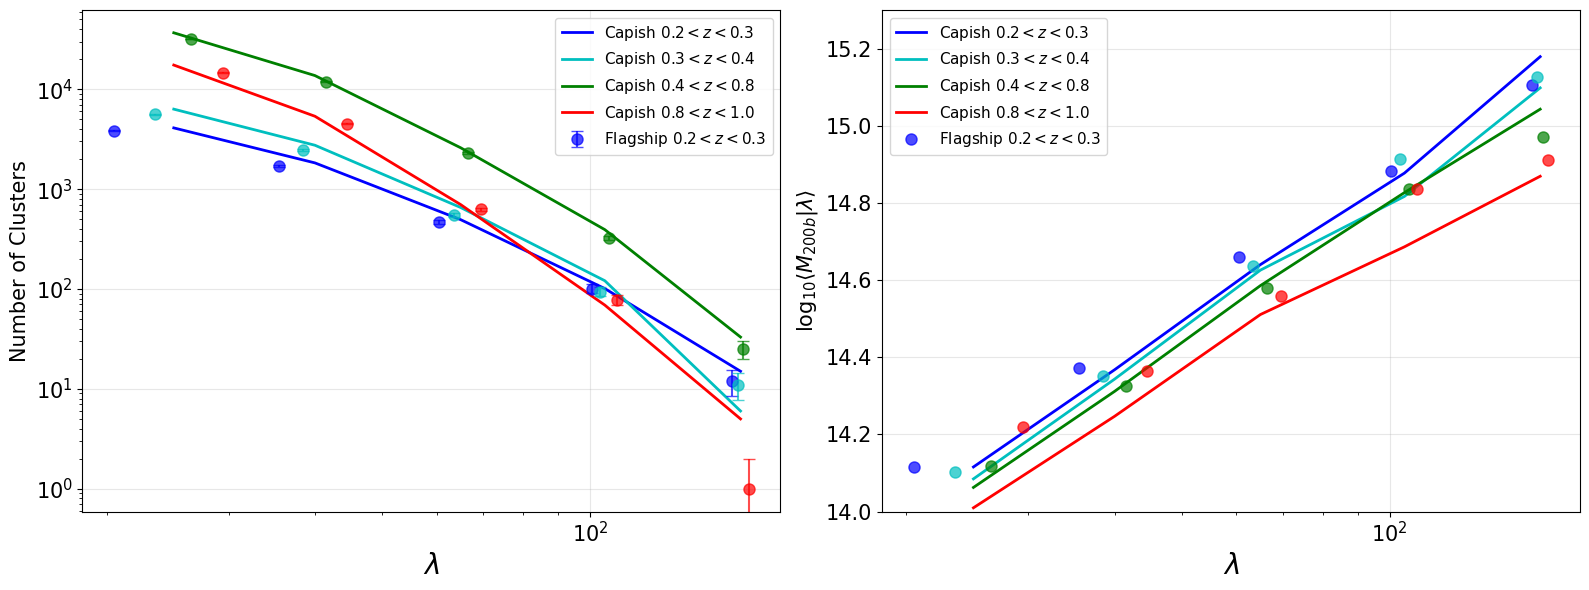


CAPISH vs FLAGSHIP COMPARISON

z-bin 1 (0.2-0.3):
  Flagship counts: [3861 1708  470  101   12]
  Capish counts:   [4101 1830  494  101   15]
  Flagship masses: [14.117, 14.372, 14.659, 14.883, 15.106]
  Capish masses:   [14.116, 14.368, 14.64 , 14.877, 15.179]

z-bin 2 (0.3-0.4):
  Flagship counts: [5627 2448  549   94   11]
  Capish counts:   [6320 2749  654  121    6]
  Flagship masses: [14.104, 14.35 , 14.635, 14.914, 15.127]
  Capish masses:   [14.085, 14.343, 14.626, 14.817, 15.098]

z-bin 3 (0.4-0.8):
  Flagship counts: [31809 11948  2292   324    25]
  Capish counts:   [36740 13705  2591   393    33]
  Flagship masses: [14.117, 14.324, 14.579, 14.835, 14.97 ]
  Capish masses:   [14.062, 14.311, 14.586, 14.827, 15.043]

z-bin 4 (0.8-1.0):
  Flagship counts: [14704  4532   625    78     1]
  Capish counts:   [17462  5364   699    69     5]
  Flagship masses: [14.219, 14.364, 14.56 , 14.836, 14.912]
  Capish masses:   [14.01 , 14.247, 14.511, 14.686, 14.869]


In [ ]:
# Plot: 1D comparison - counts and mean masses vs richness (similar to DES example)
fig = plt.figure(figsize=(16, 6))

# Colors and labels for redshift bins
colors = ['b-', 'c-', 'g-', 'r-']
z_labels = [f'$ {redshift_edges[i]:.1f} < z < {redshift_edges[i+1]:.1f} $' 
            for i in range(n_redshift_bins)]

# Subplot 1: Number of clusters
plt.subplot(121)

# Plot Capish predictions (solid lines) - transposed to iterate over redshift bins
for i in range(n_redshift_bins):
    plt.plot(richness_centers, capish_counts[:, i], colors[i], linewidth=2, 
             label=f'Capish {z_labels[i]}')

# Plot Flagship observations as points with Poisson errors
for i in range(n_redshift_bins):
    count_errors = np.sqrt(np.maximum(flagship_counts[:, i], 1))
    plt.errorbar(richness_centers + (i-1.5)*3, flagship_counts[:, i], yerr=count_errors,
                fmt='o', color=colors[i][0], markersize=8, capsize=4, alpha=0.7, 
                label=f'Flagship {z_labels[i]}' if i == 0 else None)

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\lambda$', fontsize=20)
plt.ylabel('Number of Clusters', fontsize=15)
handles, labels = plt.gca().get_legend_handles_labels()
# Only show one Flagship entry in legend
new_labels = []
new_handles = []
for h, l in zip(handles, labels):
    if l not in new_labels:
        new_labels.append(l)
        new_handles.append(h)
plt.legend(new_handles, new_labels, loc='upper right', fontsize=11)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True, alpha=0.3)

# Subplot 2: Mean M200b
plt.subplot(122)

# Plot Capish predictions (solid lines)
for i in range(n_redshift_bins):
    plt.plot(richness_centers, capish_mean_masses[:, i], colors[i], linewidth=2, 
             label=f'Capish {z_labels[i]}')

# Plot Flagship observations as points (no error bars available for mean masses)
for i in range(n_redshift_bins):
    plt.plot(richness_centers + (i-1.5)*3, flagship_mean_masses[:, i], 
            'o', color=colors[i][0], markersize=8, alpha=0.7, 
            label=f'Flagship {z_labels[i]}' if i == 0 else None)

plt.xscale('log')
plt.ylim(14.0, 15.3)
plt.xlabel(r'$\lambda$', fontsize=20)
plt.ylabel(r'log$_{10} \langle M_{200b} | \lambda \rangle$', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True, alpha=0.3)

handles, labels = plt.gca().get_legend_handles_labels()
new_labels = []
new_handles = []
for h, l in zip(handles, labels):
    if l not in new_labels:
        new_labels.append(l)
        new_handles.append(h)
plt.legend(new_handles, new_labels, loc='upper left', fontsize=11)

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*60)
print("CAPISH vs FLAGSHIP COMPARISON")
print("="*60)
for i in range(n_redshift_bins):
    print(f"\nz-bin {i+1} ({redshift_edges[i]:.1f}-{redshift_edges[i+1]:.1f}):")
    print(f"  Flagship counts: {flagship_counts[:, i].astype(int)}")
    print(f"  Capish counts:   {capish_counts[:, i].astype(int)}")
    print(f"  Flagship masses: {np.array2string(flagship_mean_masses[:, i], precision=3, separator=', ')}")
    print(f"  Capish masses:   {np.array2string(capish_mean_masses[:, i], precision=3, separator=', ')}")

/scratch/users/c/cmurray/ipykernel_3483026/1558329659.py:108: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


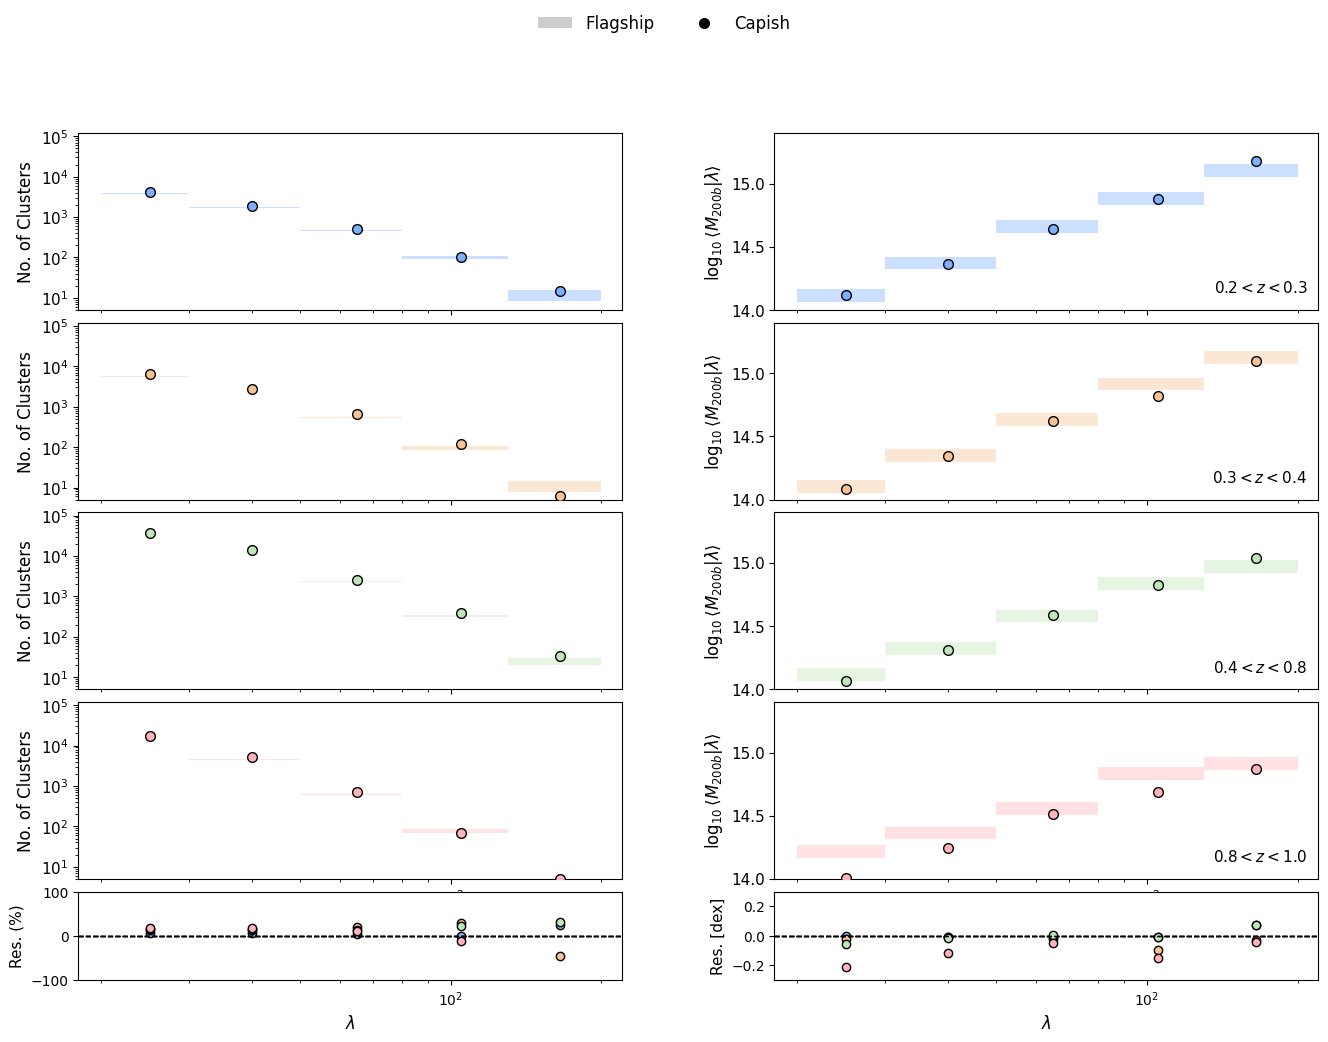

In [ ]:
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Style choices
colors = ['#7fb0ff', '#f7c394', '#bfe6b8', '#ffb3ba']   # pastel colors for 4 redshift bins
point_edge = 'k'
z_labels = [f'${redshift_edges[i]:.1f} < z < {redshift_edges[i+1]:.1f}$' 
            for i in range(n_redshift_bins)]

fig = plt.figure(figsize=(16, 11))
gs = gridspec.GridSpec(5, 2, height_ratios=[1,1,1,1,0.5], hspace=0.08, wspace=0.28)

# --- top 4 rows: data bands (shaded) and Capish points ---
for i in range(n_redshift_bins):
    ax_counts = fig.add_subplot(gs[i, 0])
    ax_mass   = fig.add_subplot(gs[i, 1])
    
    # ---- COUNTS panel: shaded band = flagship_counts +/- sqrt(flagship_counts) (Poisson-like) ----
    count_errs = np.sqrt(np.maximum(flagship_counts[:, i], 1.0))
    for j in range(n_richness_bins):
        lam_l = richness_edges[j]
        lam_r = richness_edges[j+1]
        y_low  = max(1e-1, flagship_counts[j, i] - count_errs[j])
        y_high = flagship_counts[j, i] + count_errs[j]
        ax_counts.fill_between([lam_l, lam_r], [y_low, y_low], [y_high, y_high],
                               color=colors[i], alpha=0.4, edgecolor='none')

    ax_counts.plot(richness_centers, capish_counts[:, i], 'o',
                   markerfacecolor=colors[i], markeredgecolor=point_edge, markersize=7, zorder=10)

    ax_counts.set_xscale('log')
    ax_counts.set_yscale('log')
    ax_counts.set_xlim(18, 220)
    ax_counts.set_ylim(5e0, 1.2e5)
    ax_counts.set_ylabel('No. of Clusters', fontsize=12)
    ax_counts.tick_params(labelsize=11)
    if i < n_redshift_bins-1:
        ax_counts.set_xticklabels([])
    else:
        ax_counts.set_xlabel(r'$\lambda$', fontsize=13)

    # ---- MASS panel: shaded band ----
    for j in range(n_richness_bins):
        lam_l = richness_edges[j]
        lam_r = richness_edges[j+1]
        y_low  = flagship_mean_masses[j, i] - 0.05
        y_high = flagship_mean_masses[j, i] + 0.05
        ax_mass.fill_between([lam_l, lam_r], [y_low, y_low], [y_high, y_high],
                             color=colors[i], alpha=0.4, edgecolor='none')

    ax_mass.plot(richness_centers, capish_mean_masses[:, i], 'o',
                 markerfacecolor=colors[i], markeredgecolor=point_edge, markersize=7, zorder=10)

    ax_mass.set_xscale('log')
    ax_mass.set_xlim(18, 220)
    ax_mass.set_ylim(14.0, 15.4)
    ax_mass.set_ylabel(r'$\log_{10}\langle M_{200b}|\lambda\rangle$', fontsize=12)
    ax_mass.tick_params(labelsize=11)
    if i < n_redshift_bins-1:
        ax_mass.set_xticklabels([])
    else:
        ax_mass.set_xlabel(r'$\lambda$', fontsize=13)

    ax_mass.text(0.98, 0.08, z_labels[i], transform=ax_mass.transAxes,
                 ha='right', va='bottom', fontsize=11,
                 bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=6))

# --- bottom row: residuals ---
ax_res_counts = fig.add_subplot(gs[n_redshift_bins, 0])
ax_res_mass   = fig.add_subplot(gs[n_redshift_bins, 1])

for i in range(n_redshift_bins):
    with np.errstate(divide='ignore', invalid='ignore'):
        res_counts = (capish_counts[:, i] - flagship_counts[:, i]) / flagship_counts[:, i] * 100.0
        res_counts = np.where(flagship_counts[:, i] > 0, res_counts, np.nan)
        res_masses = capish_mean_masses[:, i] - flagship_mean_masses[:, i]

    ax_res_counts.plot(richness_centers, res_counts, 'o', color=colors[i], 
                      markeredgecolor=point_edge, markersize=6)
    ax_res_counts.axhline(0.0, linestyle='--', color='k', linewidth=1)

    ax_res_mass.plot(richness_centers, res_masses, 'o', color=colors[i], 
                    markeredgecolor=point_edge, markersize=6)
    ax_res_mass.axhline(0.0, linestyle='--', color='k', linewidth=1)

ax_res_counts.set_xscale('log')
ax_res_counts.set_xlim(18, 220)
ax_res_counts.set_xlabel(r'$\lambda$', fontsize=12)
ax_res_counts.set_ylabel('Res. (%)', fontsize=11)
ax_res_counts.tick_params(labelsize=10)
ax_res_counts.set_ylim(-100, 100)

ax_res_mass.set_xscale('log')
ax_res_mass.set_xlim(18, 220)
ax_res_mass.set_xlabel(r'$\lambda$', fontsize=12)
ax_res_mass.set_ylabel('Res. [dex]', fontsize=11)
ax_res_mass.tick_params(labelsize=10)
ax_res_mass.set_ylim(-0.3, 0.3)

legend_handles = [
    Patch(facecolor='gray', alpha=0.4, label='Flagship'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='k',
           markeredgecolor=point_edge, markersize=7, label='Capish')
]
fig.legend(handles=legend_handles, loc='upper center', ncol=2, frameon=False, fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## 5. Parameter Inference

Use simulation-based inference (SBI) to infer cosmological and mass-observable parameters from Flagship data.

In [ ]:
# Check if sbi is available, install if needed
try:
    import sbi
    print(f"sbi version: {sbi.__version__}")
except ImportError:
    print("sbi not found. Install with: pip install sbi")
    print("For now, we'll show the inference workflow structure.")

sbi version: 0.25.0


In [ ]:
# Define parameter priors for inference
# We'll infer a subset of parameters, keeping others fixed

# Parameters to infer (examples):
# - Omega_m: matter density
# - sigma8: amplitude of matter fluctuations  
# - alpha_lambda, beta_lambda: mass-richness relation parameters

import torch
from sbi.utils import BoxUniform

# Define priors (adjust ranges as needed)
prior_dict = {
    'Omega_m': [0.2, 0.4],      # Reasonable range for matter density
    'sigma8': [0.7, 0.9],        # Amplitude of fluctuations
    'alpha_lambda': [-10.0, -8.5],  # MR relation normalization
    'beta_lambda': [0.6, 0.9],      # MR relation slope
}

# Create prior distribution
prior_min = torch.tensor([bounds[0] for bounds in prior_dict.values()])
prior_max = torch.tensor([bounds[1] for bounds in prior_dict.values()])
prior = BoxUniform(low=prior_min, high=prior_max)

print("Prior ranges:")
for param, bounds in prior_dict.items():
    print(f"  {param}: [{bounds[0]}, {bounds[1]}]")

print(f"\nNumber of parameters to infer: {len(prior_dict)}")

Prior ranges:
  Omega_m: [0.2, 0.4]
  sigma8: [0.7, 0.9]
  alpha_lambda: [-10.0, -8.5]
  beta_lambda: [0.6, 0.9]

Number of parameters to infer: 4


In [ ]:
# Create simulator wrapper for SBI
# SBI expects: simulator(parameters) -> observations

FIXED_GAMMA_LAMBDA = float(MASS_RICHNESS_PARAMS['gamma_lambda'])
FIXED_M_MIN = float(MASS_RICHNESS_PARAMS['M_min'])
SUMMARY_VECTOR_SIZE = 2 * n_richness_bins * n_redshift_bins

def sbi_simulator(theta_tensor):
    """
    Wrapper for UniverseSimulator compatible with SBI.

    Handles batched and single inputs and returns flattened summary statistics.

    Args:
        theta_tensor (torch.Tensor): shape (..., 4) with
            [Omega_m, sigma8, alpha_lambda, beta_lambda]
    Returns:
        torch.Tensor: shape (..., SUMMARY_VECTOR_SIZE)
    """
    if theta_tensor.ndim == 1:
        theta_batch = theta_tensor.unsqueeze(0)
        squeeze_output = True
    else:
        theta_batch = theta_tensor
        squeeze_output = False

    outputs = []
    for theta in theta_batch:
        theta_np = theta.detach().cpu().numpy()
        full_params = [
            float(theta_np[0]),
            float(theta_np[1]),
            float(theta_np[2]),
            float(theta_np[3]),
            FIXED_GAMMA_LAMBDA,
            FIXED_M_MIN,
        ]
        summary_stats = simulator.run_simulation(full_params)
        counts, masses = summary_statistic_to_sensible_format(
            summary_stats, n_richness_bins, n_redshift_bins
        )
        data_vector = np.concatenate([counts.flatten(), masses.flatten()])
        outputs.append(torch.tensor(data_vector, dtype=torch.float32))

    outputs_tensor = torch.stack(outputs)
    return outputs_tensor[0] if squeeze_output else outputs_tensor

print("SBI simulator wrapper created")
print(f"Summary vector length: {SUMMARY_VECTOR_SIZE}")


SBI simulator wrapper created
Summary vector length: 40


In [ ]:
# Prepare observed data (Flagship) for inference
observed_counts = flagship_counts.flatten()
observed_masses = flagship_mean_masses.flatten()
observed_data = np.concatenate([observed_counts, observed_masses])
observed_data_tensor = torch.tensor(observed_data, dtype=torch.float32)

print(f"Observed data vector shape: {observed_data.shape}")
print(f"Number of summary statistics: {len(observed_data)}")
print(f"  - Count bins: {len(observed_counts)}")
print(f"  - Mass bins: {len(observed_masses)}")

Observed data vector shape: (40,)
Number of summary statistics: 40
  - Count bins: 20
  - Mass bins: 20


In [ ]:
# Train neural posterior estimator (SNPE)
import time
import pickle
from pathlib import Path
from sbi.inference import SNPE

posterior_cache_path = project_root / 'notebooks' / 'calum' / 'flagship_posterior.pkl'
force_retrain = False  # set to True to force a fresh training run
num_simulations = 400   # increase for tighter posteriors (runtime scales linearly)

if posterior_cache_path.exists() and not force_retrain:
    with open(posterior_cache_path, 'rb') as handle:
        posterior = pickle.load(handle)
    print(f'Loaded cached posterior from {posterior_cache_path}')
else:
    print(f'Running {num_simulations} simulations to train the posterior. This may take a while...')
    torch.manual_seed(42)
    np.random.seed(42)

    theta_bank = prior.sample((num_simulations,))
    x_bank = torch.zeros(num_simulations, SUMMARY_VECTOR_SIZE, dtype=torch.float32)

    start = time.time()
    for idx, theta in enumerate(theta_bank):
        x_bank[idx] = sbi_simulator(theta)
        if (idx + 1) % 50 == 0 or idx + 1 == num_simulations:
            elapsed = time.time() - start
            print(f'  {idx + 1:4d}/{num_simulations} simulations '
                  f'(avg {elapsed / (idx + 1):.2f} s each)')
    total = time.time() - start
    print(f'Simulations complete in {total / 60:.2f} min. Training neural posterior...')

    inference = SNPE(prior=prior)
    density_estimator = inference.append_simulations(theta_bank, x_bank, proposal=prior).train()
    posterior = inference.build_posterior(density_estimator)

    with open(posterior_cache_path, 'wb') as handle:
        pickle.dump(posterior, handle)
    print(f'Saved posterior to {posterior_cache_path}')

print('Posterior ready. Use `posterior.sample()` with an observation to draw samples.')


Loaded cached posterior from /pbs/home/c/cmurray/cluster_likelihood/notebooks/calum/flagship_posterior.pkl
Posterior ready. Use `posterior.sample()` with an observation to draw samples.


### Posterior Sampling and Visualisation

In [ ]:
# Sample the posterior for the Flagship data vector and a Capish mock catalogue
try:
    import corner
except ImportError as exc:
    raise ImportError('Install corner with `pip install corner` before running this cell.') from exc

param_labels = [r'$\Omega_m$', r'$\sigma_8$', r'$\alpha_\lambda$', r'$\beta_\lambda$']
num_posterior_samples = 50000

posterior_samples_flagship = posterior.sample((num_posterior_samples,), x=observed_data_tensor)
posterior_samples_flagship_np = posterior_samples_flagship.cpu().numpy()

fiducial_theta = torch.tensor([
    float(COSMO_PARAMS['Omega_m']),
    float(COSMO_PARAMS['sigma8']),
    float(MASS_RICHNESS_PARAMS['alpha_lambda']),
    float(MASS_RICHNESS_PARAMS['beta_lambda']),
], dtype=torch.float32)
mock_data_tensor = sbi_simulator(fiducial_theta)
posterior_samples_mock = posterior.sample((num_posterior_samples,), x=mock_data_tensor)
posterior_samples_mock_np = posterior_samples_mock.cpu().numpy()

def summarise(samples, labels, label_name):
    percentiles = np.percentile(samples, [16, 50, 84], axis=0)
    print(f"\n{label_name} credible intervals:")
    for lbl, p16, p50, p84 in zip(labels, percentiles[0], percentiles[1], percentiles[2]):
        print(f"  {lbl}: {p50:.3f} (+{p84 - p50:.3f}/-{p50 - p16:.3f})")

print('Posterior samples ready:')
print(f"  Flagship samples: {posterior_samples_flagship_np.shape}")
print(f"  Mock samples:     {posterior_samples_mock_np.shape}")

summarise(posterior_samples_flagship_np, param_labels, 'Flagship')
summarise(posterior_samples_mock_np, param_labels, 'Capish mock')


51966it [00:00, 123750.12it/s]                           


Capish raw counts shape: (5, 4)
Capish raw masses shape: (5, 4)


51638it [00:00, 112340.36it/s]                           

Posterior samples ready:
  Flagship samples: (50000, 4)
  Mock samples:     (50000, 4)

Flagship credible intervals:
  $\Omega_m$: 0.293 (+0.046/-0.044)
  $\sigma_8$: 0.804 (+0.053/-0.052)
  $\alpha_\lambda$: -9.280 (+0.419/-0.404)
  $\beta_\lambda$: 0.750 (+0.029/-0.030)

Capish mock credible intervals:
  $\Omega_m$: 0.271 (+0.045/-0.038)
  $\sigma_8$: 0.800 (+0.053/-0.053)
  $\alpha_\lambda$: -9.270 (+0.416/-0.405)
  $\beta_\lambda$: 0.753 (+0.029/-0.030)


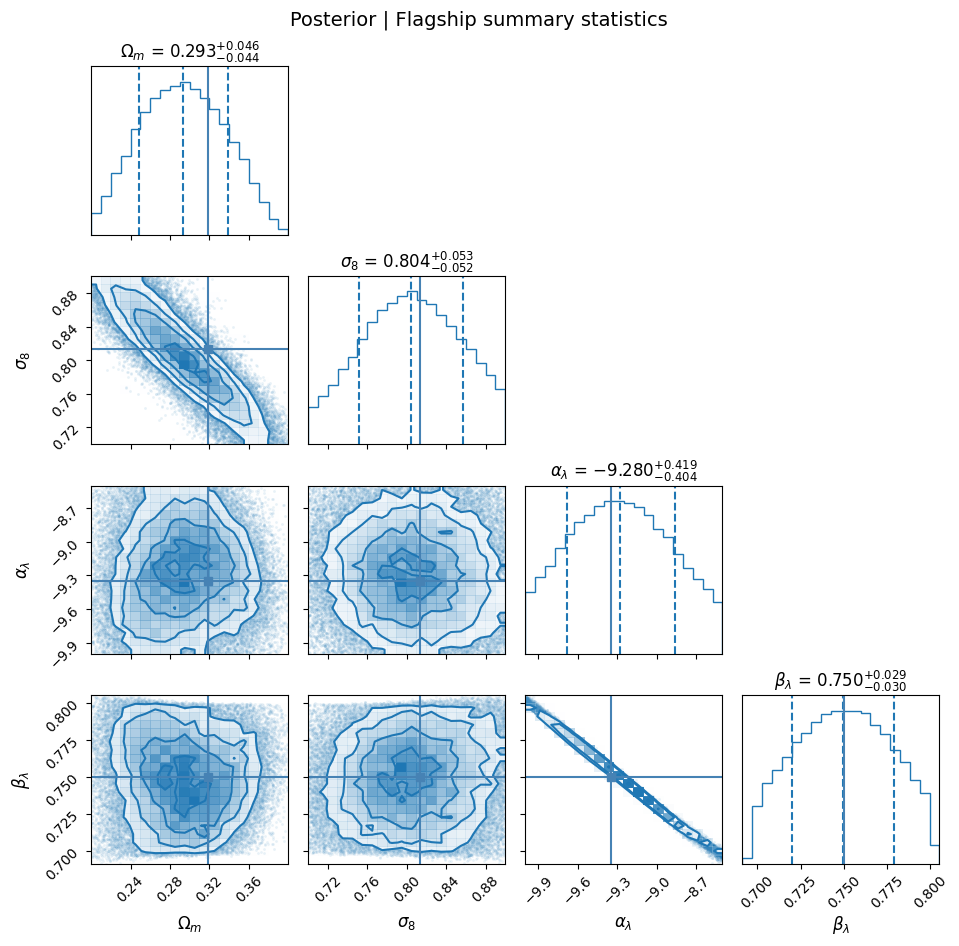

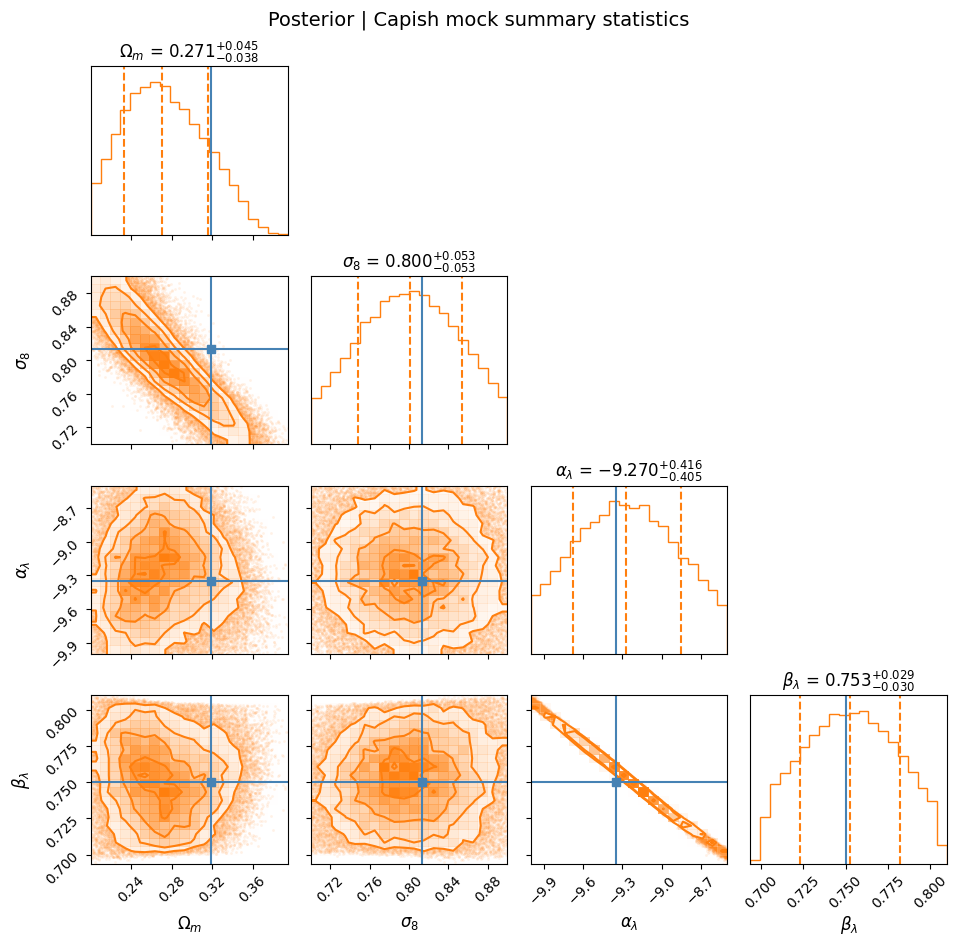

In [ ]:
# Corner plots for Flagship and Capish mock posteriors
corner_kwargs = dict(labels=param_labels, show_titles=True, title_fmt='.3f', quantiles=[0.16, 0.5, 0.84], label_kwargs={'fontsize': 12})

fig_flagship = corner.corner(
    posterior_samples_flagship_np,
    truths=fiducial_theta.cpu().numpy(),
    color='#1f77b4',
    **corner_kwargs
)
fig_flagship.suptitle('Posterior | Flagship summary statistics', fontsize=14)
fig_flagship.tight_layout()

fig_mock = corner.corner(
    posterior_samples_mock_np,
    truths=fiducial_theta.cpu().numpy(),
    color='#ff7f0e',
    **corner_kwargs
)
fig_mock.suptitle('Posterior | Capish mock summary statistics', fontsize=14)
fig_mock.tight_layout()
